## Train and Benchmark and Neural Decoder  with Viterbi Decoder.

This notebook contains pipeline how to train a neural decoder model for decoding convolution code over AWGN Channel at 1/2-RSC signal.



In [ ]:
#  !pip install tensorflow==2.14


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [ ]:
!pip install scikit-commpy

## Import required packages

In [ ]:
import sys
# Replace '/content/drive/My Drive/path/to/deepcom' with the actual path to your 'deepcom' folder in your Drive
sys.path.append('/content/drive/MyDrive/final_turbo_code/turbo-nn/')


In [25]:
import multiprocessing as mp
import time
import numpy as np
import commpy as cp
import tensorflow as tf

from deepcom.model import NRSCDecoder           # Neural Decoder Model
from deepcom.metrics import BER, BLER           # metrics to benchmark Neural Decoder Model
from deepcom.utils import corrupt_signal        # simulate a AWGN Channel

from deepcom.dataset import create_dataset      # Create synthetic dataset
from deepcom.dataset import data_genenerator    # data loader for Tensorflow

import  matplotlib.pyplot  as plt
%matplotlib inline

## Define Hyper-paramemeters for the experiment

In [ ]:
# # Number of training data
# BLOCK_LEN = 10
# NUM_TRAINING_DATA = 1200
# NUM_TESTING_DATA  = 1000

# # Communication Algo via Deep Learning
# #(page 5, last paragraph)
# NOISE_TYPE ='awgn'
# SNR_train = 0.0


# # Network Architectures
# NUM_LAYERS = 2
# NUM_HIDDEN_UNITS = 40

# # Hyper-parameters for training
# BATCH_SIZE = 50     # depends on size of GPU, should be a factor of num_data
# LEARNING_RATE = 1e-3
# DROPOUT_RATE= 0.75


# CONSTRAINT_LEN = 3     # num of shifts in Conv. Encoder
# TRACE_BACK_DEPTH = 15  # (?) a parameter Viterbi Encoder

In [26]:
# Number of training data
BLOCK_LEN = 100
NUM_TRAINING_DATA = 120000
NUM_TESTING_DATA  = 10000

# Communication Algo via Deep Learning
#(page 5, last paragraph)
NOISE_TYPE ='awgn'
SNR_train = 0.0


# Network Architectures
NUM_LAYERS = 2
NUM_HIDDEN_UNITS = 400

# Hyper-parameters for training
BATCH_SIZE = 500       # depends on size of GPU, should be a factor of num_data
LEARNING_RATE = 1e-3
DROPOUT_RATE= 0.75


CONSTRAINT_LEN = 3     # num of shifts in Conv. Encoder
TRACE_BACK_DEPTH = 15  # (?) a parameter Viterbi Encoder

## Generate Synthetic Dataset for training/evaluation

In [27]:
from commpy.channelcoding import Trellis
#  Generator Matrix (octal representation)
G = np.array([[0o7, 0o5]])
M = np.array([CONSTRAINT_LEN - 1])
trellis = Trellis(M, G, feedback=0o7, code_type='rsc')

# Create dataset
print('Creating training data....')

# X_train shape = [NUM_TRAINING_DATA, BLOCK_LENGTH, 2]
# Y_train shape = [NUM_TRAINING_DATA, BLOCK_LENGTH, 1]
X_train, Y_train = create_dataset(
    NUM_TRAINING_DATA,
    BLOCK_LEN,
    trellis,
    noise_type=NOISE_TYPE, snr=SNR_train, seed=2018)

print('Creating testing data....')
# X_test shape = [NUM_TESTING_DATA, BLOCK_LENGTH, 2]
# Y_test shape = [NUM_TESTING_DATA, BLOCK_LENGTH, 1]
X_test, Y_test = create_dataset(
    NUM_TESTING_DATA,
    BLOCK_LEN,
    trellis,
    noise_type=NOISE_TYPE, snr=SNR_train, seed=1111)

print('Number of training sequences {}'.format(len(X_train)))
print('Number of testing sequences {}'.format(len(Y_test)))
# print(X_train.shape, Y_train.shape)

Creating training data....
Creating testing data....
Number of training sequences 120000
Number of testing sequences 10000


In [28]:
import tensorflow as tf

print(tf.__version__)
!python --version

2.17.1
Python 3.10.12


## Define Neural Decoder Model

In [ ]:
# Construct Neural Decoder
inputs = tf.keras.Input(shape=(None, 2))
outputs = NRSCDecoder(
    inputs,
    is_training=True,
    num_layers=NUM_LAYERS,
    hidden_units=NUM_HIDDEN_UNITS,
    dropout=DROPOUT_RATE)
model = tf.keras.Model(inputs, outputs)

# Set up training
model.compile('adam', 'binary_crossentropy', metrics=[BER])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, 2)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, None, 80)            │          10,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, None, 80)            │             320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, None, 80)            │          29,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, None, 80)            │             320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, None, 1)             │              81 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,561 (158.44 KB)

 Trainable params: 40,241 (157.19 KB)

 Non-trainable params: 320 (1.25 KB)

## Start Training/Eval Pipeline

In [ ]:
# Set up Data Loader using tf.Dataset
train_set = data_genenerator(X_train, Y_train, BATCH_SIZE, shuffle=True)
test_set = data_genenerator(X_test, Y_test, BATCH_SIZE, shuffle=False)

# Backup best model
backup = tf.keras.callbacks.ModelCheckpoint(
  filepath='BiGRU.keras',  # Changed the file extension to .h5
  monitor='val_loss',
  save_best_only=True)

# Stop training early if the model seems to overfit
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0,
    patience=3,
    verbose=0, mode='auto')

history = model.fit(
    train_set,
    steps_per_epoch=len(X_train) //BATCH_SIZE,
    validation_data=test_set,
    validation_steps= len(X_test) //BATCH_SIZE,
    callbacks=[early_stopping, backup],
    epochs=10)

model = tf.keras.models.load_model('BiGRU.keras', custom_objects={'BER': BER}) # Changed the file extension to .h5


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - ber: 0.5149 - loss: 0.8526 - val_ber: 0.4944 - val_loss: 0.6931
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - ber: 0.4984 - loss: 0.8134 - val_ber: 0.5056 - val_loss: 0.6933
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - ber: 0.4936 - loss: 0.7929 - val_ber: 0.5056 - val_loss: 0.6933
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - ber: 0.4926 - loss: 0.7605 - val_ber: 0.5056 - val_loss: 0.6933


In [ ]:
import tensorflow as tf

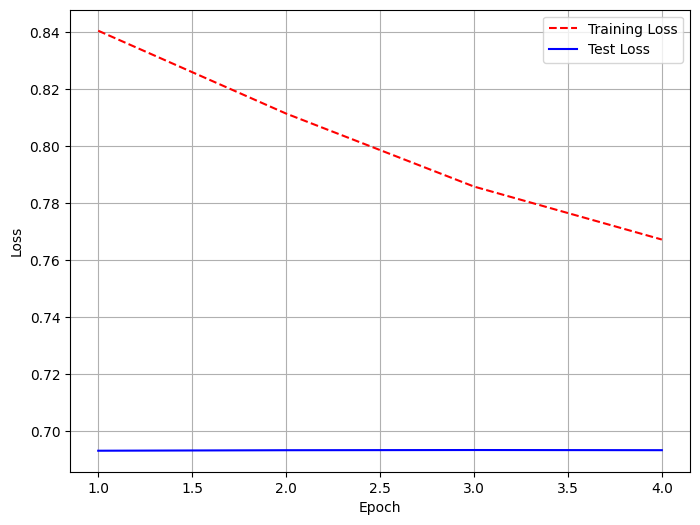

In [ ]:
# Count of the number of epochs
epochs = range(1, len(history.history['loss']) + 1)
# Visualize loss history
plt.figure(figsize=(8, 6))
plt.plot(epochs, history.history['loss'], 'r--')
plt.plot(epochs, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

## Benchmark Neural Decoder

In [ ]:
def benchmark_neural_decoder(noisy_inputs, labels):

    # Set up data generator
    Y = np.reshape(labels, (-1, BLOCK_LEN, 1))
    X = np.reshape(np.array(noisy_inputs)[:, :2*BLOCK_LEN], (-1, BLOCK_LEN, 2))
    test_set = data_genenerator(X, Y, BATCH_SIZE, shuffle=False)

    # Make predictions in batch
    decoded_bits = model.predict(
        test_set,
        steps=len(Y) // BATCH_SIZE)

    # Compute hamming distances
    original_bits = np.reshape(Y, (-1, BLOCK_LEN)).astype(int)
    decoded_bits =  np.reshape(np.round(decoded_bits), (-1, BLOCK_LEN)).astype(int)
    hamming_dist = np.not_equal(original_bits, decoded_bits)

    return np.sum(hamming_dist, axis=1)

def benchmark_viterbi(message_bits, noisy_bits, sigma):

    # make fair comparison between (100, 204) convolutional code and RNN decoder
    # Reference: Author's code
    noisy_bits[-2*int(M):] = 0

    # Viterbi Decoder on Conv. Code
    decoded_bits = cp.channelcoding.viterbi_decode(
        coded_bits=noisy_bits.astype(float),
        trellis=trellis,
        tb_depth=TRACE_BACK_DEPTH,
        decoding_type='unquantized')

    # Number of bit errors (hamming distance)
    hamming_dist = cp.utilities.hamming_dist(
        message_bits.astype(int),
        decoded_bits[:-int(M)])
    return hamming_dist


# #################################################################
# For every SNR_db, we generates new noisy signals
# for fair comparision.
# #################################################################
def generate_noisy_input(message_bits, trellis, sigma):
    # Encode message bit
    coded_bits = cp.channelcoding.conv_encode(message_bits, trellis)
    # Corrupt message on BAWGN Channel
    coded_bits = corrupt_signal(coded_bits, noise_type='awgn', sigma=sigma)
    return coded_bits, message_bits

In [ ]:
viterbiBERs, viterbiBLERs = [], []
neuralBERs, neuralBLERs = [], []

pool = mp.Pool(processes=mp.cpu_count())
labels = np.reshape(Y_test, (-1, BLOCK_LEN)).astype(int)
try:
    SNRs  = np.linspace(0, 7.0, 8)
    for snr in SNRs:
        snr_linear = snr + 10 * np.log10(1./2.)
        sigma = np.sqrt(1. / (2. * 10 **(snr_linear / 10.)))
        print('[SNR]={:.2f}'.format(snr))

        # Generates new noisy signals
        result = pool.starmap(
            func=generate_noisy_input,
            iterable=[(msg_bits, trellis, sigma) for msg_bits in labels])

        X, Y =  zip(*result)

        # #################################################################
        # BENCHMARK NEURAL DECODER
        # #################################################################
        nn_start = time.time()
        hamm_dists = benchmark_neural_decoder(X, Y)

        nn_ber = sum(hamm_dists) / np.product(np.shape(Y))
        nn_bler = np.count_nonzero(hamm_dists) / len(Y)

        neuralBERs.append(nn_ber)
        neuralBLERs.append(nn_bler)
        print('\tNeural Decoder:  [BER]={:5.7f} [BLER]={:5.3f} -- {:3.3f}s'.format(
            nn_ber, nn_bler, time.time() - nn_start))

        # #################################################################
        # BENCHMARK VITERBI DECODER
        # #################################################################
        vi_start = time.time()
        hamm_dists = pool.starmap(benchmark_viterbi, [(y, x, sigma) for x, y in zip(X, Y)])

        ber = sum(hamm_dists) / np.product(np.shape(Y))
        bler = np.count_nonzero(hamm_dists) / len(Y)

        viterbiBERs.append(ber)
        viterbiBLERs.append(bler)
        print('\tViterbi Decoder: [BER]={:5.7f} [BLER]={:5.3f} -- {:3.3f}s'.format(
              ber, bler, time.time() - vi_start))

except Exception as e:
    print(e)
finally:
    pool.close()

[SNR]=0.00
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


<ipython-input-20-00c9b836da8f>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noisy_bits[-2*int(M):] = 0
<ipython-input-20-00c9b836da8f>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noisy_bits[-2*int(M):] = 0
<ipython-input-20-00c9b836da8f>:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  decoded_bits[:-int(M)])
<ipython-input-20-00c9b836da8f>:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.

	Neural Decoder:  [BER]=0.4944000 [BLER]=0.996 -- 1.113s


<ipython-input-21-1009566f8595>:40: RuntimeWarning: overflow encountered in scalar add
  ber = sum(hamm_dists) / np.product(np.shape(Y))


	Viterbi Decoder: [BER]=-16443605128905.1523438 [BLER]=1.000 -- 2.196s
[SNR]=1.00
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
	Neural Decoder:  [BER]=0.4944000 [BLER]=0.996 -- 0.639s
	Viterbi Decoder: [BER]=-16443605128905.1523438 [BLER]=1.000 -- 2.418s
[SNR]=2.00
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
	Neural Decoder:  [BER]=0.4944000 [BLER]=0.996 -- 0.417s
	Viterbi Decoder: [BER]=-16443605128905.1523438 [BLER]=1.000 -- 1.454s
[SNR]=3.00
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
	Neural Decoder:  [BER]=0.4944000 [BLER]=0.996 -- 0.633s
	Viterbi Decoder: [BER]=-16443605128905.1523438 [BLER]=1.000 -- 1.436s
[SNR]=4.00
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
	Neural Decoder:  [BER]=0.4944000 [BLER]=0.996 -- 0.636s
	Viterbi Decoder: [BER]=-16443605128905.1523438 [BLER]=1.000 -- 1.453s
[SNR]=5.00
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
	Neural Decoder:  [BER]=0.4944000 [BLER]=0.996 -- 0.633s
	Viterbi Decoder: [BER]=-16443605128905.1523438 [BLER]=1.000 -- 1.445s
[SNR]=6.00
20/20 ━━━━━━━━━━━━━━━━━

# Result

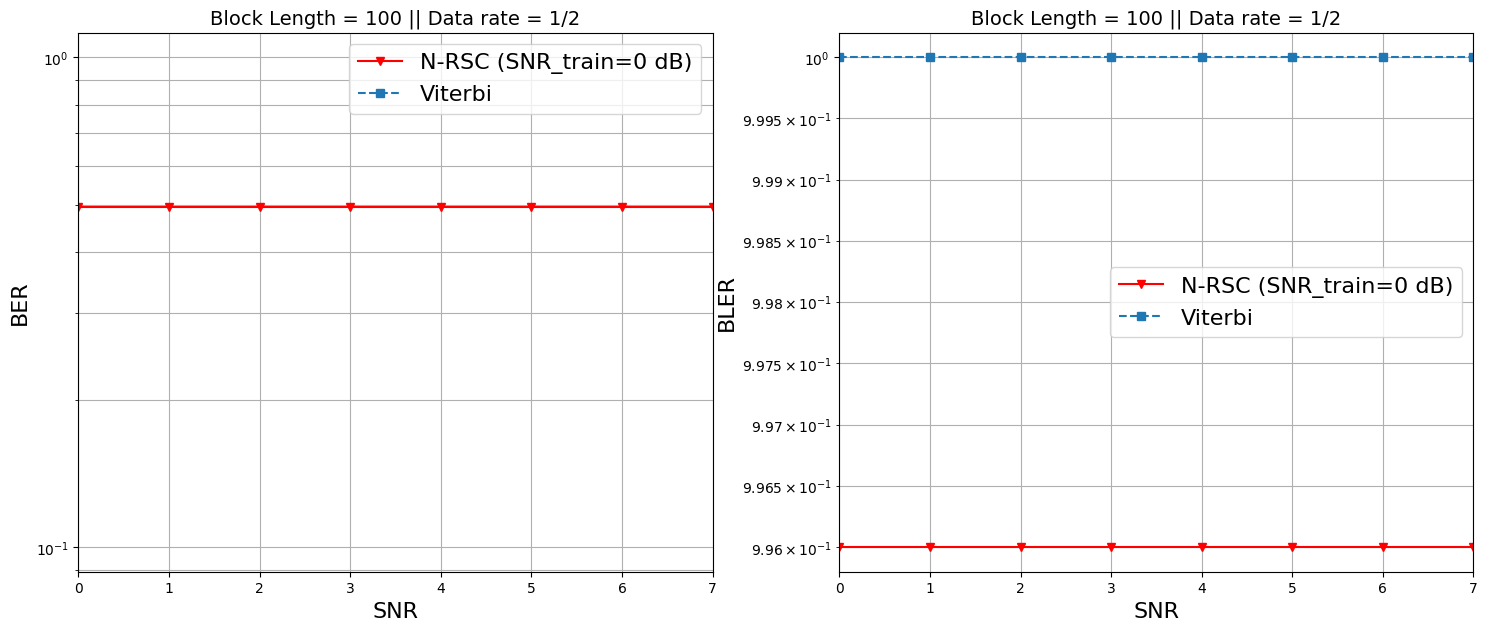

In [ ]:
# ###################################
# Plot Bit Error Rate (BER) Curve
# ###################################
plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
plt.title('Block Length = 100 || Data rate = 1/2', fontsize=14)

plt.semilogy(SNRs, neuralBERs, '-vr')
plt.semilogy(SNRs, viterbiBERs, 's--')
plt.legend(['N-RSC (SNR_train=0 dB)', 'Viterbi'], fontsize=16)
plt.xlabel('SNR', fontsize=16)
plt.xlim(xmin=SNRs[0], xmax=SNRs[-1])  # this line
plt.ylabel('BER', fontsize=16)
plt.grid(True, which='both')
plt.savefig('result_ber_block_length_1000_snr0.png')

# ###################################
# Plot Block Error Rate (BLER) Curve
# ###################################
plt.subplot(1, 2, 2)
plt.title('Block Length = 100 || Data rate = 1/2', fontsize=14)

plt.semilogy(SNRs, neuralBLERs, '-vr')
plt.semilogy(SNRs, viterbiBLERs, 's--')
plt.ylabel('BLER', fontsize=16)
plt.xlabel('SNR', fontsize=16)
plt.legend(['N-RSC (SNR_train=0 dB)', 'Viterbi'], fontsize=16)

plt.xlim(xmin=SNRs[0], xmax=SNRs[-1])  # this line
plt.grid(True, which='both')
plt.savefig('result_bler_block_length_1000_snr0.png')

##  Benchmark on K = 1000

In [ ]:
_, Y_test = create_dataset(NUM_TESTING_DATA, 100, trellis, snr=0.0, seed=1111)

In [ ]:
viterbiBERs, viterbiBLERs = [], []
neuralBERs, neuralBLERs = [], []

pool = mp.Pool(processes=mp.cpu_count())
labels = np.reshape(Y_test, (-1, BLOCK_LEN)).astype(int)
try:
    SNRs  = np.linspace(0, 7.0, 8)
    for snr in SNRs:
        snr_linear = snr + 10 * np.log10(1./2.)
        sigma = np.sqrt(1. / (2. * 10 **(snr_linear / 10.)))
        print('[SNR]={:.2f}'.format(snr))

        # Generates new noisy signals
        result = pool.starmap(
            func=generate_noisy_input,
            iterable=[(msg_bits, trellis, sigma) for msg_bits in labels])

        X, Y =  zip(*result)

        # #################################################################
        # BENCHMARK NEURAL DECODER
        # #################################################################
        nn_start = time.time()
        hamm_dists = benchmark_neural_decoder(X, Y)

        nn_ber = sum(hamm_dists) / np.product(np.shape(Y))
        nn_bler = np.count_nonzero(hamm_dists) / len(Y)

        neuralBERs.append(nn_ber)
        neuralBLERs.append(nn_bler)
        print('\tNeural Decoder:  [BER]={:5.7f} [BLER]={:5.3f} -- {:3.3f}s'.format(
            nn_ber, nn_bler, time.time() - nn_start))

        # #################################################################
        # BENCHMARK VITERBI DECODER
        # #################################################################
        vi_start = time.time()
        hamm_dists = pool.starmap(benchmark_viterbi, [(y, x, sigma) for x, y in zip(X, Y)])

        ber = sum(hamm_dists) / np.product(np.shape(Y))
        bler = np.count_nonzero(hamm_dists) / len(Y)

        viterbiBERs.append(ber)
        viterbiBLERs.append(bler)
        print('\tViterbi Decoder: [BER]={:5.7f} [BLER]={:5.3f} -- {:3.3f}s'.format(
              ber, bler, time.time() - vi_start))

except Exception as e:
    print(e)
finally:
    pool.close()

[SNR]=0.00
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
	Neural Decoder:  [BER]=0.4978600 [BLER]=1.000 -- 3.465s


<ipython-input-20-00c9b836da8f>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noisy_bits[-2*int(M):] = 0
<ipython-input-20-00c9b836da8f>:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  decoded_bits[:-int(M)])
<ipython-input-20-00c9b836da8f>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  noisy_bits[-2*int(M):] = 0
<ipython-input-20-00c9b836da8f>:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.

In [ ]:
# ###################################
# Plot Bit Error Rate (BER) Curve
# ###################################
plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
plt.title('Block Length = 100 || Data rate = 1/2', fontsize=14)

plt.semilogy(SNRs, neuralBERs, '-vr')
plt.semilogy(SNRs, viterbiBERs, 's--')
plt.legend(['N-RSC (SNR_train=0 dB)', 'Viterbi'], fontsize=16)
plt.xlabel('SNR', fontsize=16)
plt.xlim(xmin=SNRs[0], xmax=SNRs[-1])  # this line
plt.ylabel('BER', fontsize=16)
plt.grid(True, which='both')
plt.savefig('result_ber_block_length_1000_snr0.png')

# ###################################
# Plot Block Error Rate (BLER) Curve
# ###################################
plt.subplot(1, 2, 2)
plt.title('Block Length = 100 || Data rate = 1/2', fontsize=14)

plt.semilogy(SNRs, neuralBLERs, '-vr')
plt.semilogy(SNRs, viterbiBLERs, 's--')
plt.ylabel('BLER', fontsize=16)
plt.xlabel('SNR', fontsize=16)
plt.legend(['N-RSC (SNR_train=0 dB)', 'Viterbi'], fontsize=16)

plt.xlim(xmin=SNRs[0], xmax=SNRs[-1])  # this line
plt.grid(True, which='both')
plt.savefig('result_bler_block_length_1000_snr0.png')